In [907]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score

In [908]:
#%%timeit: 2min 22s ± 302 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# wv_from_text = KeyedVectors.load_word2vec_format("numberbatch-en-19.08.txt")

# %%timeit: 723 ms ± 8.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
numberbatch = pickle.load(open("numberbatch-en-19.08-en.pickle", 'rb'))

In [909]:
len(numberbatch.vocab)

516782

In [910]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [911]:
ds_techniques = pd.read_csv('datasets/silknow/zeste_technique_en_post.csv').rename(columns={'technique':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,This piece is from a large set of at least eig...,http://data.silknow.org/vocabulary/168
1,"In the style of Daniel Marot, this bed was mad...",http://data.silknow.org/vocabulary/168
2,"Upon Degas's death in 1917, more than 150 figu...",http://data.silknow.org/vocabulary/366
3,The medallion on the front shows Saint Joseph ...,http://data.silknow.org/vocabulary/366
4,The embroidered decoration of this mirror fram...,http://data.silknow.org/vocabulary/366


In [912]:
ds_techniques.label.value_counts()

http://data.silknow.org/vocabulary/87     819
http://data.silknow.org/vocabulary/379    700
http://data.silknow.org/vocabulary/192    484
http://data.silknow.org/vocabulary/366    422
http://data.silknow.org/vocabulary/236    108
http://data.silknow.org/vocabulary/168     71
Name: label, dtype: int64

In [913]:
len(ds_techniques)

2604

In [914]:
def get_word_neighborhood(word, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity(word, ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [915]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [916]:
def get_words_neighborhood(words, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [917]:
sorted(ds_techniques.label.unique())

['http://data.silknow.org/vocabulary/168',
 'http://data.silknow.org/vocabulary/192',
 'http://data.silknow.org/vocabulary/236',
 'http://data.silknow.org/vocabulary/366',
 'http://data.silknow.org/vocabulary/379',
 'http://data.silknow.org/vocabulary/87']

In [918]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'musical_artist', 'tea_rose', 'rosa_laevigata', 'rosebud', 'rose_colored', 'rosemaling', 'roseless', 'rosa_rubiginosa', 'rosaceae', 'rose_bowl', 'old_rose', 'rosé', 'шипшина', 'rosewater', 'roselike', 'roze', 'ruusa', 'roser', 'roseling', 'serviceberry', 'rosaniline', 'musk_rose', 'վարդենի', 'itburnu', 'rose_cold', 'compass_rose', 'rosa_pimpinellifolia', 'rising', 'quincite', 'roseness', 'rosewood', 'purple', 'rose_water', 'mahaleb', 'arctic_raspberry', 'rise', 'black_spot', 'jetbead', 'rous', 'rosehip', 'rosa_omeiensis', 'rose_topaz', 'roziero', 'redden', 'rosa_canina', 'amelanchier', 'rosaceous', 'rosa_foetida', 'lolajöb', 'thorn', 'rosed', 'rosarian', 'rosula', 'noisette', 'jack', 'ורדא', 'rosa_rugosa', 'rock_rose', 'rosa_damascena', 'rosen', 'english_rose', 'pop_music', 'pink', 'roseleaf', 'rose_cut', 'china_rose', 'hawthorn', 'mawar', 'rooj', 'garden', 'rose_window', 'rose_syrup', 'red', 'hybrid_tea', 'rosulate', 'rosebush', 'rose_slug', 'compass_card', 'rose_ch

In [919]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""

mapping = { 
             'http://data.silknow.org/vocabulary/168': 'damask',
             'http://data.silknow.org/vocabulary/192': 'brocade',
             'http://data.silknow.org/vocabulary/236': 'tabby',
             'http://data.silknow.org/vocabulary/366': 'satin',
             'http://data.silknow.org/vocabulary/379': 'velvet',
             'http://data.silknow.org/vocabulary/87': 'embroidery'             }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

6
['brocade', 'damask', 'embroidery', 'satin', 'tabby', 'velvet']


In [920]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 2.94 s, sys: 0 ns, total: 2.94 s
Wall time: 2.93 s


In [921]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'brocade': 2733,
 'damask': 2694,
 'embroidery': 4351,
 'satin': 5403,
 'tabby': 2177,
 'velvet': 14802}

In [922]:
labels_cgr.keys()

dict_keys(['brocade', 'damask', 'embroidery', 'satin', 'tabby', 'velvet'])

In [923]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [924]:
ds_techniques.text[0]

'This piece is from a large set of at least eight side chairs, four settees, four stools, and two side tables formerly attributed to James Moore (ca. 1670–1726) and said to have been made for Stowe, Buckinghamshire, a provenance now questioned.'

In [925]:
data_silknow = ds_techniques.text.tolist()

In [926]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [927]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 340 ms, sys: 1.94 s, total: 2.28 s
Wall time: 4.33 s


In [928]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [929]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [930]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 0 ns, sys: 2.02 s, total: 2.02 s
Wall time: 2.07 s


In [931]:


predictions[:10]

[2, 3, 5, 5, 2, 5, 3, 2, 2, 2]

In [932]:

prediction_labels = [labels[p] for p in predictions]

In [933]:
set(prediction_labels)

{'brocade', 'damask', 'embroidery', 'satin', 'tabby', 'velvet'}

In [934]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Techniques

In [935]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('techniques-en-predictions.csv')

              precision    recall  f1-score   support

     brocade      0.343     0.624     0.443       266
      damask      0.183     0.394     0.250        33
  embroidery      0.484     0.568     0.522       697
       satin      0.327     0.317     0.322       435
       tabby      0.000     0.000     0.000         4
      velvet      0.723     0.433     0.541      1169

    accuracy                          0.468      2604
   macro avg      0.343     0.389     0.346      2604
weighted avg      0.546     0.468     0.485      2604



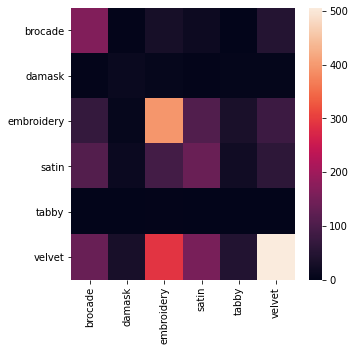

In [936]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

In [937]:
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=3):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
top_predictions = generate_top_predictions(data_preprocessed, labels_cgr)
top_prediction_labels = [[labels[p] for p in top_p] for top_p in top_predictions]


# "Top-k" evaluation

In [938]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

     brocade      0.562     0.965     0.710       282
      damask      0.437     0.674     0.530        46
  embroidery      0.692     0.782     0.734       725
       satin      0.661     0.615     0.637       454
       tabby      0.009     0.200     0.018         5
      velvet      0.963     0.617     0.752      1092

    accuracy                          0.700      2604
   macro avg      0.554     0.642     0.564      2604
weighted avg      0.780     0.700     0.717      2604



In [939]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

     brocade      0.738     0.992     0.846       360
      damask      0.845     0.870     0.857        69
  embroidery      0.894     0.894     0.894       819
       satin      0.879     0.830     0.854       447
       tabby      0.009     0.250     0.018         4
      velvet      0.997     0.771     0.870       905

    accuracy                          0.852      2604
   macro avg      0.727     0.768     0.723      2604
weighted avg      0.903     0.852     0.870      2604

